In [ ]:
import glob, scipy, json, re, time, pickle
import pandas as pd
import workers
from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt
import feather, pytz, spacy, datetime
from itertools import chain
from datetime import timezone
import en_core_web_sm
nlp = en_core_web_sm.load()

from sentence_transformers import SentenceTransformer
sbert = SentenceTransformer('bert-base-nli-mean-tokens')

# Preprocess replies

In [2]:
def extract_tweet_info(x):
    return [x['id'], int(x['created_at']/1000), x.get('user_id', ''), x['tweet']]

file_list = glob.glob('./dat/covid_antibiotics_replies/*.json')

sampled_tweets = []
for file in file_list:
    for line in open(file, 'r', encoding='utf-8'):
        sampled_tweets.append(extract_tweet_info(json.loads(line)))
        
sampled_tweets_df = pd.DataFrame(sampled_tweets, columns=['id', 'created', 'uid', 'text'])
print(sampled_tweets_df.shape)

(16396, 4)


In [3]:
covid_df = sampled_tweets_df.copy()
covid_df.index = covid_df.created.apply(lambda x: datetime.datetime.fromtimestamp(x, pytz.utc))
covid_df = covid_df.sort_index()

criteria  = (covid_df.index.year==2020)
covid_df = covid_df[criteria]
print("size of df in the year 2020:", covid_df.shape)

covid_df = covid_df.drop_duplicates()
print("size of df after dropping duplicates:", covid_df.shape)

size of df in the year 2020: (16383, 4)
size of df after dropping duplicates: (16383, 4)


(array([737425., 737439., 737456., 737470., 737485., 737499., 737516.]),
 <a list of 7 Text xticklabel objects>)

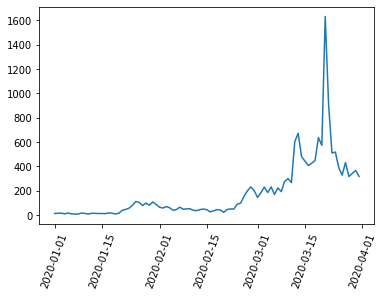

In [4]:
covid_df = covid_df[covid_df.index.date<=datetime.date(2020,3,31)]
pd.plotting.register_matplotlib_converters()

plt.plot(covid_df.groupby(lambda x: x.date)['text'].count())
plt.xticks(rotation=70)

## Clean text

In [5]:
num_processors = 10
p=Pool(processes = num_processors)
%time output = p.map(workers.twitter_preprocessing, covid_df.text)
p.close()
p.terminate()

Wall time: 185 ms


In [ ]:
sbert_embs = np.array(sbert.encode(output, show_progress_bar=True, batch_size=20))

In [ ]:
# fname = './covid_tweet_replies_embs_mar31_utc_timezone.npy'
# np.save(fname, np.array(sbert_embs))

## Calculate contextual similarity

In [6]:
fname = './dat/covid_tweet_replies_embs_mar31_utc_timezone.npy'
sbert_embs = np.load(fname)

In [7]:
#https://www.who.int/emergencies/diseases/novel-coronavirus-2019/advice-for-public/myth-busters
who_official = "No, antibiotics do not work against viruses, only bacteria. The new coronavirus (2019-nCoV) is a virus and, therefore, antibiotics should not be used as a means of prevention or treatment. However, if you are hospitalized for the 2019-nCoV, you may receive antibiotics because bacterial co-infection is possible."

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
who_embs = sbert.encode([who_official], show_progress_bar=True, batch_size=20)
sims = cosine_similarity(who_embs, sbert_embs)
sims = sims.flatten()

covid_df = covid_df.assign(sims=sims)
covid_df = covid_df.sort_values(by=['sims'], ascending=False)

Batches: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]


# Collect parent tweets

In [10]:
import tweepy
import config # Twitter api app credential

auth = tweepy.OAuthHandler(config.ckey, config.csec)
auth.set_access_token(config.akey, config.asec)
api = tweepy.API(auth)

In [ ]:
import time
downloaded_threads = glob.glob('./dat/tweet_threads/*.json')
downloaded_threads = [x.split('\\')[-1].split('.')[0] for x in downloaded_threads]
for ix, target_id in enumerate(covid_df.id):
    if str(target_id) in downloaded_threads:
        continue
    else:
        print(ix, "target:", target_id)
        thread = []
        try:
            tmp = api.get_status(id=target_id, tweet_mode='extended')._json
            thread.append(tmp)
            tmp_id = tmp['in_reply_to_status_id']; 
        except:
            with open("F:/code/hyunuk/antibiotics/dat/tweet_threads/%s.json" % target_id, 'w') as f:
                json.dump(thread, f)
            continue
                   
        while (tmp_id is not None):
            #pd.isna(tmp_id)==False
            if len(thread)>2: #can be changed if we want to track further
                break
            try:
                tmp = api.get_status(id=tmp_id, tweet_mode='extended')._json
                thread.append(tmp)
                tmp_id = tmp['in_reply_to_status_id']            
                time.sleep(2.1)
            except:
                thread.append({'id': tmp_id, 'created_at': 'unavailable'})
                tmp_id = None

        with open("./dat/tweet_threads/%s.json" % target_id, 'w') as f:
            json.dump(thread, f)   

## Merge parent tweets with tweet replies

In [12]:
op_df = []
for ix, target_id in enumerate(covid_df.id):
    if ix%1000==999: print(ix+1)
    try:
        with open("./dat/tweet_threads/%s.json" % target_id, 'r') as f:
            tmp = json.load(f)
        if (tmp[-1]['created_at']=='unavailable') or (len(tmp)<=1):
            continue
        else:            
            op = tmp[1] # direct parent
            op_df.append([op['id'], target_id, op['user']['id'], op['user']['name'],
                          op['user']['verified'], op['full_text'], 
                          op['retweet_count'], op['favorite_count']])
    except:
        continue
        
op_df = pd.DataFrame(op_df, columns = ['post_id', 'reply_id', 'uid', 'uname', 'verified', 
                                       'parent_text', 'parent_ret', 'parent_likes'])

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


In [13]:
df_merged = covid_df.merge(op_df, left_on='id', right_on='reply_id')
df_merged = df_merged[df_merged.uid_x!=df_merged.uid_y] ### created by different user

df_merged = df_merged[['post_id', 'reply_id', 'uid_y', 'uname', 'verified',
                       'parent_text', 'parent_ret', 'parent_likes', 'uid_x', 'created', 'text', 'sims']]
df_merged = df_merged.reset_index(drop=True)
df_merged.columns = ['pid', 'cid', 'uid', 'uname', 'verified', 
                     'parent_text', 'parent_ret', 'parent_likes', 'commentor_id',
                     'comment_created_at', 'reply', 'similarity']
df_merged = df_merged.drop_duplicates()
print(df_merged.shape)

(12263, 12)


In [16]:
import importlib
importlib.reload(workers)

num_processors = 10
p=Pool(processes = num_processors)
output = p.map(workers.detect_lang, df_merged.parent_text) 

df_merged['lang'] = output
df_merged = df_merged[df_merged.lang=='en']  # written in English
df_merged = df_merged.reset_index(drop=True)

p.close()
p.terminate()
print("the number of english comments", df_merged.shape)

num_processors = 5
p=Pool(processes = num_processors)
output = p.map(workers.twitter_preprocessing, df_merged.parent_text)
p.close()
p.terminate()

df_merged = df_merged.assign(parent_text = output)
df_merged = df_merged.drop('lang', axis=1)
df_merged = df_merged.assign(parent_text_lower = [x.lower() for x in df_merged.parent_text])

the number of english comments (11751, 13)


## Apply query

In [17]:
criteria1 = df_merged.parent_text_lower.str.contains("corona|coronavirus|covid19|covid-19|2019-nCoV|wuhanvirus")
criteria2 = df_merged.parent_text_lower.str.contains("wuhan") & df_merged.parent_text.str.contains("virus")
criteria3 = criteria1 | criteria2 
idx = criteria3
idx[idx.isna()] = False
df_merged = df_merged[idx==True]
print('containing corona related keywords:', df_merged.shape)
print("number of unique posts is", len(set(df_merged.cid)))

containing corona related keywords: (3318, 13)
number of unique posts is 3318


In [19]:
idx = df_merged.parent_text_lower.str.contains("antibiotic|antibiotics")
idx[idx.isna()] = False
df_merged = df_merged[idx==True]
print('containing antibiotic related keywords:', df_merged.shape)
print("number of unique posts is", len(set(df_merged.cid)))

df_merged.pid = ['_'+str(x) for x in df_merged.pid]
df_merged.cid = ['_'+str(x) for x in df_merged.cid]
df_merged.uid = ['_'+str(x) for x in df_merged.uid]
df_merged.commentor_id = ['_'+str(x) for x in df_merged.commentor_id]

containing antibiotic related keywords: (573, 13)
number of unique posts is 573


### Choose top 200 parents

In [20]:
top_200 = df_merged[['pid', 'uid', 'uname', 'parent_text', 'similarity', 'comment_created_at', 'reply']]
top_200 = top_200.reset_index(drop=True)
uniq_pids = set()
for i in range(top_200.shape[0]):
    uniq_pids.add(top_200.pid[i])
    if len(uniq_pids)==200: # choose n unique parent tweets
        end_idx = i
        break        
top_200 = top_200[:end_idx+1]

In [21]:
parent_reply_merged = top_200[['pid', 'uid', 'parent_text']]
parent_reply_merged = parent_reply_merged.drop_duplicates()
parent_reply_merged = parent_reply_merged.reset_index(drop=True)
#parent_reply_merged.to_csv("./res/covid_parent_reply_final.csv", index=False)

# Process non-replies

size of df in the year 2020: (8780, 4)
size of df after dropping duplicates: (8780, 4)


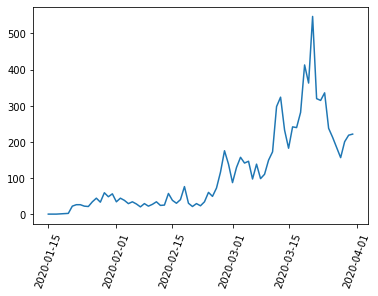

In [26]:
file_list = glob.glob('./dat/covid_antibiotics_non_replies/*.json')
    
def extract_tweet_info(x):
    return [x['id'], int(x['created_at']/1000), x.get('user_id', ''), x['tweet']]

sampled_tweets = []
for file in file_list:
    for line in open(file, 'r', encoding='utf-8'):
        sampled_tweets.append(extract_tweet_info(json.loads(line)))
        
sampled_tweets_df = pd.DataFrame(sampled_tweets, columns=['id', 'created', 'uid', 'text'])
sampled_tweets_df.index = sampled_tweets_df.created.apply(lambda x: datetime.datetime.fromtimestamp(x, pytz.utc))
sampled_tweets_df = sampled_tweets_df.sort_index()

criteria  = (sampled_tweets_df.index.year==2020)
sampled_tweets_df = sampled_tweets_df[criteria]
print("size of df in the year 2020:", sampled_tweets_df.shape)
sampled_tweets_df = sampled_tweets_df.drop_duplicates()
print("size of df after dropping duplicates:", sampled_tweets_df.shape)

sampled_tweets_df = sampled_tweets_df[sampled_tweets_df.index.date<=datetime.date(2020,3,31)]

pd.plotting.register_matplotlib_converters()
plt.plot(sampled_tweets_df.groupby(lambda x: x.date)['text'].count()[1:])
plt.xticks(rotation=70)

df_subset = sampled_tweets_df.copy()

In [33]:
num_processors = 20
p=Pool(processes = num_processors)
%time output = p.map(workers.detect_lang, df_subset.text)

df_subset = df_subset.assign(lang = output)
df_subset = df_subset[df_subset.lang=='en']
df_subset = df_subset.reset_index(drop=True)

p.close()
p.terminate()
print("the number of english comments", df_subset.shape)

import importlib
importlib.reload(workers)

num_processors = 5
p=Pool(processes = num_processors)
%time output = p.map(workers.twitter_preprocessing, df_subset.text)
p.close()
p.terminate()

df_subset = df_subset.assign(text = output)
df_subset = df_subset.drop('lang', axis=1)
df_subset = df_subset.assign(misinfo = 0)

Wall time: 191 ms


In [34]:
covid_df_non_replies = df_subset[['id', 'uid', 'text']]
covid_df_non_replies_sampled = covid_df_non_replies.sample(200, random_state=20200331)
covid_df_non_replies_sampled = covid_df_non_replies_sampled.assign(misinfo=0)
covid_df_non_replies_sampled.id = ['_'+str(x) for x in covid_df_non_replies_sampled.id]
covid_df_non_replies_sampled.uid = ['_'+str(x) for x in covid_df_non_replies_sampled.uid]
#covid_df_non_replies_sampled.to_csv('./res/covid_tweet_non_replies_sampled.csv', index=False)

# Upstream and downstream

In [38]:
our_strategy = pd.read_csv("./res/covid_parent_reply_final_labeled.csv", encoding='latin-1')
keyword_based_search = pd.read_csv("./res/covid_tweet_non_replies_sampled_labeled.csv", encoding='latin-1')

In [39]:
misinfo_df = our_strategy[our_strategy.misinfo!=0]
misinfo_unique_uid = list(set(misinfo_df.uid))
misinfo_unique_uid = [x[1:] for x in misinfo_unique_uid]

len(misinfo_unique_uid)

55

In [40]:
n_friends = []
n_followers = []
user_names = []
selected_uids = []
for uid in misinfo_unique_uid:
    try:
        tmp = api.get_user(user_id=uid)
    except:
        continue
    selected_uids.append(uid)
    user_names.append(tmp._json['name'])
    n_friends.append(tmp._json['friends_count'])
    n_followers.append(tmp._json['followers_count'])
    time.sleep(0.5)

In [41]:
misinfo_unique_uid_df = pd.DataFrame({'uid': selected_uids, 'uname': user_names,
                                      'n_friends': n_friends, 'n_followers': n_followers})

In [43]:
### we only considered accounts which number of friends and that of followers are both less than 10000

misinfo_unique_uid_df_selected = misinfo_unique_uid_df[(misinfo_unique_uid_df.n_friends<10000) &
                                                      (misinfo_unique_uid_df.n_followers<10000)]
misinfo_unique_uid_df_selected = misinfo_unique_uid_df_selected.reset_index(drop=True)
misinfo_unique_uid_df_selected.head()

,uid,uname,n_friends,n_followers
0,1169715382971768833,Gracie P Smith,1168,871
1,839948922411954176,Chief Two Guns,1884,687
2,2616394622,Ghia Griffin,4320,3011
3,27188418,Darnell de Palma,85,1366
4,975239623575191552,Chris Mark,779,291


## Retrieve list of friends

In [ ]:
friends_by_uid = {}
for ix, uid in enumerate(misinfo_unique_uid_df_selected.uid):
    print(ix, "starts -", uid)
    friends = []
    for page in tweepy.Cursor(api.friends_ids, user_id=uid).pages():
        friends.extend(page)
        time.sleep(60)
    friends_by_uid[uid] = friends

In [ ]:
# import pickle
# with open("./res/covid_friends_of_misinfo_parents_200.pickle", 'wb') as f:
#     pickle.dump(friends_by_uid, f)

## Retrieve list of followers

In [ ]:
followers_by_uid = {}
for ix, uid in enumerate(misinfo_unique_uid_df_selected.uid):
    print(ix, "starts -", uid)
    followers = []
    for page in tweepy.Cursor(api.followers_ids, user_id=uid).pages():
        followers.extend(page)
        time.sleep(60)
    followers_by_uid[uid] = followers

In [ ]:
# import pickle
# with open("./res/covid_followers_of_misinfo_parents_200.pickle", 'wb') as f:
#     pickle.dump(followers_by_uid, f)

## Get misinformation in both streams

In [44]:
with open("./res/covid_friends_of_misinfo_parents_200.pickle", 'rb') as f:
    friends_by_uid = pickle.load(f)
with open("./res/covid_followers_of_misinfo_parents_200.pickle", 'rb') as f:
    followers_by_uid = pickle.load(f)

### all friends and followers

In [45]:
all_friends = list(set(list(chain(*list(friends_by_uid.values())))))
for uid in misinfo_unique_uid_df_selected.uid:
    if uid in all_friends:
        all_friends.remove(uid)
print(len(all_friends))

all_followers = list(set(list(chain(*list(followers_by_uid.values())))))
for uid in misinfo_unique_uid_df_selected.uid:
    if uid in all_followers:
        all_followers.remove(uid)
print(len(all_followers))

54786
57712


In [46]:
covid_df_non_replies_generated_by_friends = covid_df_non_replies[covid_df_non_replies.uid.isin(all_friends)]
covid_df_non_replies_generated_by_friends = covid_df_non_replies_generated_by_friends.drop_duplicates()
covid_df_non_replies_generated_by_friends.id = ['_'+str(x) for x in covid_df_non_replies_generated_by_friends.id]
covid_df_non_replies_generated_by_friends.uid = ['_'+str(x) for x in covid_df_non_replies_generated_by_friends.uid]
print("friends:", covid_df_non_replies_generated_by_friends.shape)

covid_df_non_replies_generated_by_followers = covid_df_non_replies[covid_df_non_replies.uid.isin(all_followers)]
covid_df_non_replies_generated_by_followers = covid_df_non_replies_generated_by_followers.drop_duplicates()
covid_df_non_replies_generated_by_followers.id = ['_'+str(x) for x in covid_df_non_replies_generated_by_followers.id]
covid_df_non_replies_generated_by_followers.uid = ['_'+str(x) for x in covid_df_non_replies_generated_by_followers.uid]
print("followers:", covid_df_non_replies_generated_by_followers.shape)

friends: (213, 3)
followers: (110, 3)


In [47]:
covid_df_non_replies_generated_by_friends.to_csv("./res/covid_twitter_friends_of_parent.csv", index=False)
covid_df_non_replies_generated_by_followers.to_csv("./res/covid_twitter_followers_of_parent.csv", index=False)

# Draw SNR figure

In [52]:
our_strategy = pd.read_csv("./res/covid_parent_reply_final_labeled.csv", encoding='latin-1')
keyword_based_search = pd.read_csv("./res/covid_tweet_non_replies_sampled_labeled.csv", encoding='latin-1')
friends_labeled = pd.read_csv("./res/covid_twitter_friends_of_parent_labeled.csv")
followers_labeled = pd.read_csv("./res/covid_twitter_followers_of_parent_labeled.csv")

In [67]:
snr_df = pd.DataFrame({'type': 'Our strategy', 'Category': our_strategy.misinfo})
snr_df = snr_df.append(pd.DataFrame({'type': 'Keyword-based search', 'Category': keyword_based_search.misinfo}))
snr_df = snr_df.append(pd.DataFrame({'type': 'Friends', 
                                     'Category': friends_labeled.misinfo}))
snr_df = snr_df.append(pd.DataFrame({'type': 'Followers', 
                                     'Category': followers_labeled.misinfo}))

snr_df.Category = ['Category ' + str(x) for x in snr_df.Category]
snr_df = snr_df.assign(value = 1)

snr_df = snr_df.groupby(['type', 'Category']).agg({'value': 'sum'})
snr_df = snr_df.groupby(level=0).apply(lambda x: x / float(x.sum())).reset_index()

In [68]:
snr_df = snr_df[snr_df.Category!='Category 0']

summarize = snr_df.groupby('type').value.sum().to_frame().reset_index()
summarize['Category'] = "Total"
snr_df = snr_df.append(summarize)

In [69]:
snr_df = snr_df.append(pd.DataFrame({'Category': ['Category 3'], 'value': [0.0],
                                    'type': ['Keyword-based search']}))
#snr_df = snr_df.append(pd.DataFrame({'Category': ['Category 2', 'Category 3', 'Category 4'], 
#                                     'value': [0.0, 0.0, 0.0],
#                                    'type': ['Friends']*3}))
#snr_df = snr_df.append(pd.DataFrame({'Category': ['Category 2', 'Category 4'], 
#                                     'value': [0.0, 0.0],
#                                    'type': ['Followers']*2}))


snr_df['type'] = pd.Categorical(snr_df['type'], ["Our strategy", "Keyword-based search",
                                                 "Friends", "Followers", ])
snr_df = snr_df.sort_values(by=['type', 'Category'])
snr_df

,Category,type,value
15,Category 1,Our strategy,0.200000
16,Category 2,Our strategy,0.060000
17,Category 3,Our strategy,0.010000
18,Category 4,Our strategy,0.020000
3,Total,Our strategy,0.290000
11,Category 1,Keyword-based search,0.090000
12,Category 2,Keyword-based search,0.005000
0,Category 3,Keyword-based search,0.000000
13,Category 4,Keyword-based search,0.045000
2,Total,Keyword-based search,0.140000


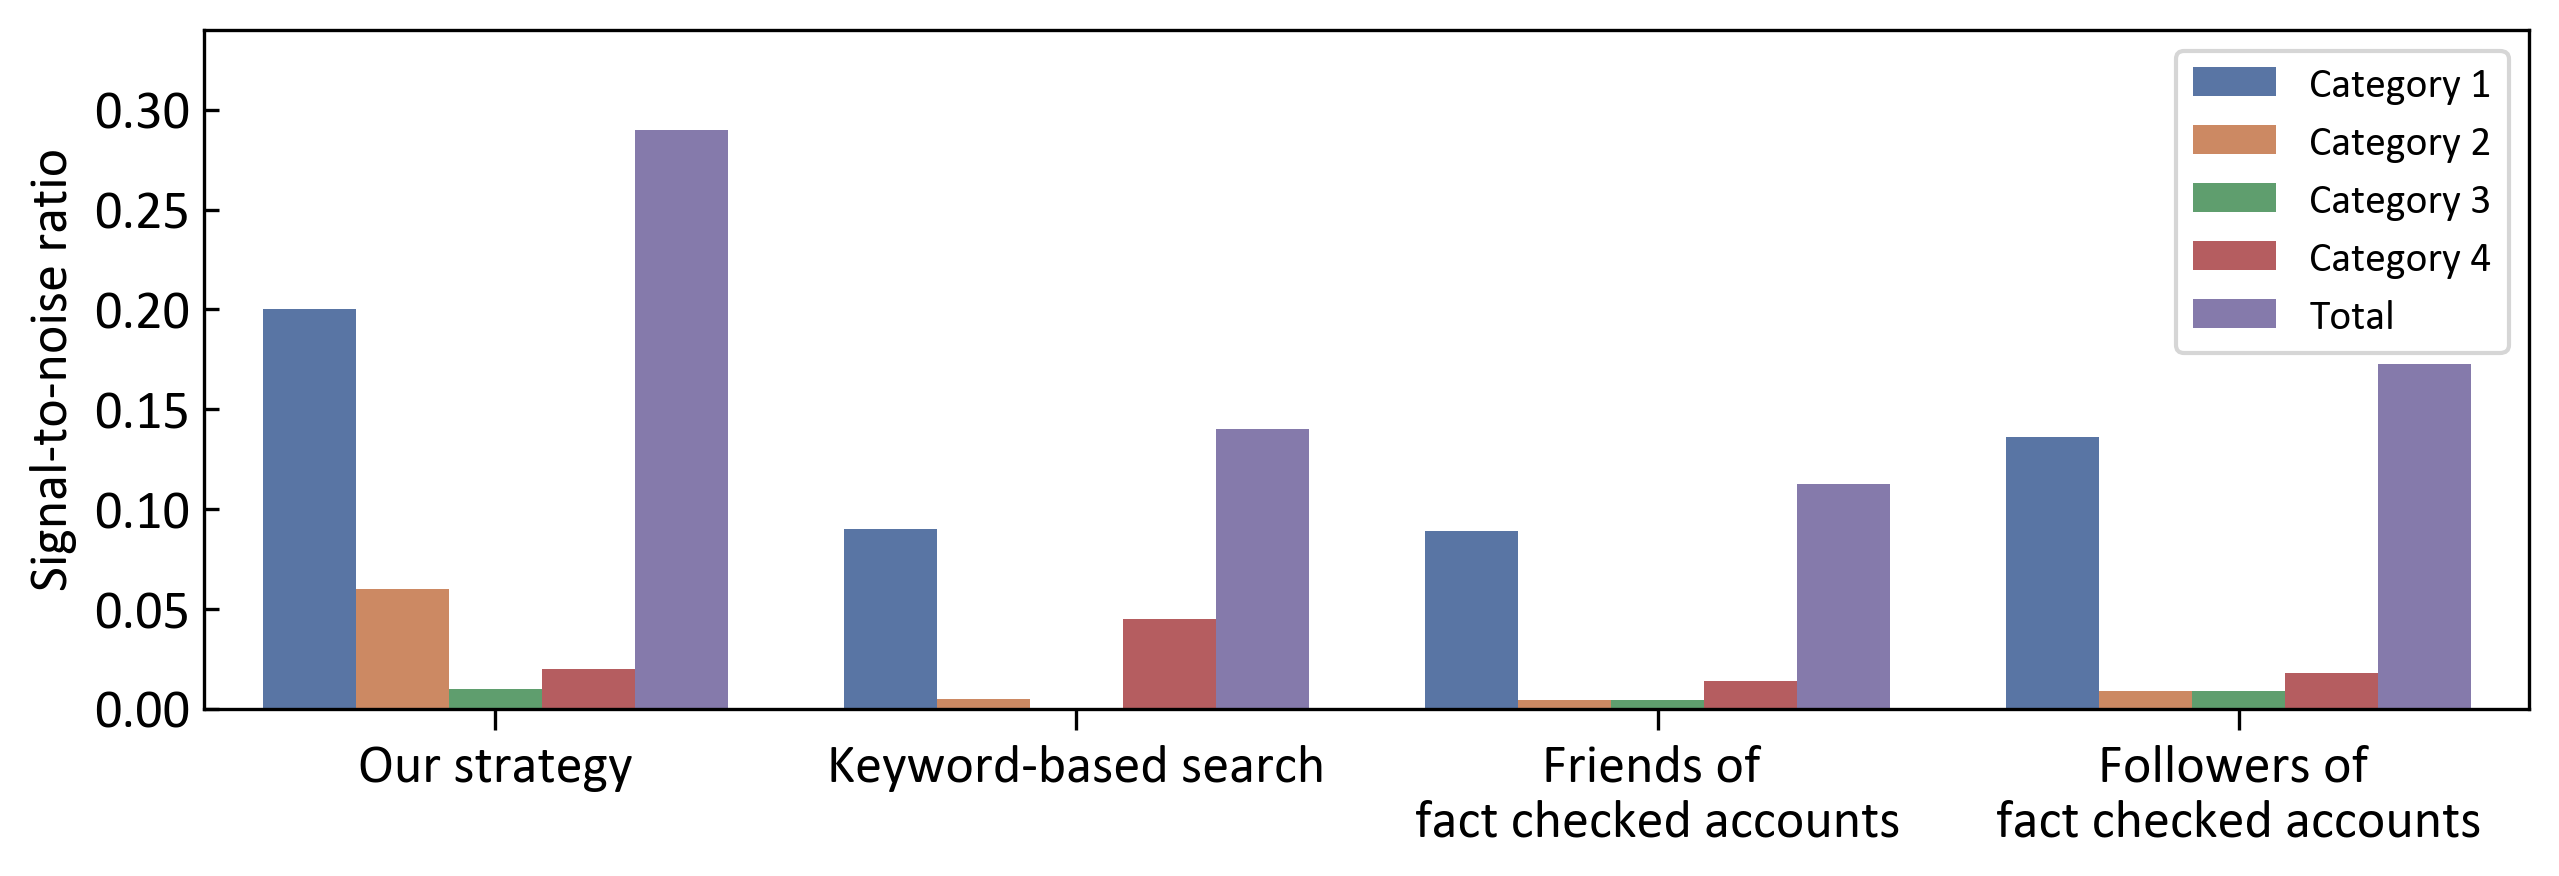

In [80]:
import seaborn as sns
plt.figure(figsize=(10,3), dpi=300)

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
nect = ['#8a5e3f', '#07936f', '#8d6935', '#eee7cd', '#38466b', '#0a0d1e']
custom = sns.color_palette("deep", 6)

ax = sns.barplot(x='type', y='value', hue='Category', data=snr_df, palette=custom)
plt.xlabel('')
plt.ylabel('Signal-to-noise ratio', fontsize=13, fontname='calibri')

plt.xticks([0,1,2,3], 
           ['Our strategy', 'Keyword-based search', 'Friends of \nfact checked accounts', 
            'Followers of \nfact checked accounts', ],
            fontsize=13, fontname='calibri', rotation=0)
plt.yticks(fontsize=13, fontname='calibri')
plt.tick_params(axis='x',length=5)
plt.tick_params(direction='in', axis='y')
plt.ylim(0, 0.34)

L = plt.legend(fontsize=10, loc=1)
plt.setp(L.texts, family='calibri')
plt.savefig("./res/figure2.png", bbox_inches='tight')